# jigsaw Unintended Bias in Toxicity Classification

## The Question
-  #### The main area of focus is a machine learning models that can `identify toxicity in online conversations`, where toxicity is defined as anything `rude`, `disrespectful` or otherwise `likely to make someone leave a discussion`.

### Steps to cover
- Preprocessing
    - Remove special characters or symbols
    - Cleaning puntuation and removing numbers
    - Convert whole dataset to lowers case
    - Remove stop words
    - Stemming (Snowball stemmer) 
- Train-Test data splitting
    - Whole document to be transformed into term frequency 
    - Every unique word would be considered as a freature 
    - Every word would be evaluated for frequency
- Term Frequence data implementation
- OvR (Ove-verses-Rest) classification for multiclass and Logisctic Regression for Binary Class classification

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
from nltk.corpus import stopwords # stopwords
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
import unicodedata
import html

# Data Exploration

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [3]:
train.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [5]:
test.head(5)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
train.shape

(1804874, 45)

In [8]:
test.shape

(97320, 2)

In [9]:
print(" \nshow the boolean Dataframe : \n\n", train.isnull())
  
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      train.isnull().sum())

 
show the boolean Dataframe : 

             id  target  comment_text  severe_toxicity  obscene  \
0        False   False         False            False    False   
1        False   False         False            False    False   
2        False   False         False            False    False   
3        False   False         False            False    False   
4        False   False         False            False    False   
...        ...     ...           ...              ...      ...   
1804869  False   False         False            False    False   
1804870  False   False         False            False    False   
1804871  False   False         False            False    False   
1804872  False   False         False            False    False   
1804873  False   False         False            False    False   

         identity_attack  insult  threat  asian  atheist  ...  article_id  \
0                  False   False   False   True     True  ...       False   
1                  

### Target Variable Exploration

(array([1266229.,  160959.,  170695.,    5515.,   57142.,   72099.,
          26784.,   14620.,   21605.,    9226.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

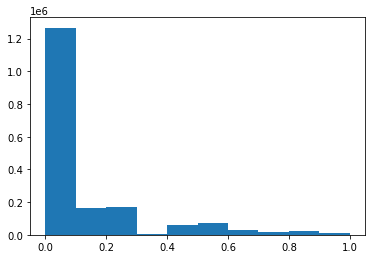

In [10]:
plt.hist(train['target'])

As we have seen from the exploration that the data is not in a state to be feed to the model. Thus, we need to clean the text inorder to use it in the model. Thus, we need to reform and clean the texts.

### Text cleaning

In [11]:
# Taking samples from the training dataset

train_sample = train.sample(frac = 0.1, random_state = 42, axis = 'index')
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180487 entries, 286892 to 313137
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   180487 non-null  int64  
 1   target                               180487 non-null  float64
 2   comment_text                         180487 non-null  object 
 3   severe_toxicity                      180487 non-null  float64
 4   obscene                              180487 non-null  float64
 5   identity_attack                      180487 non-null  float64
 6   insult                               180487 non-null  float64
 7   threat                               180487 non-null  float64
 8   asian                                40363 non-null   float64
 9   atheist                              40363 non-null   float64
 10  bisexual                             40363 non-null   float64
 11  black   

In [12]:
# Creating a cleaning function

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [13]:
train_sample['clean_comment_text'] = train_sample['comment_text'].apply(clean_text)
test['clean_comment_text'] = test['comment_text'].apply(clean_text)

In [14]:
train_sample['clean_comment_text'].head(5)

286892     breathe fresh air someone embrace common sense...
419218     jewish friend one tell zionist control canadav...
1055330    possible collusion trump affiliate debunk stat...
1382764    exactly need gdp spend cap federal level would...
256049     comment even vote ndp pq trudeau demonstrably ...
Name: clean_comment_text, dtype: object

In [15]:
test['clean_comment_text'].head(5)

0                                apply president trump
1          malfeasance administrator board waste money
2    rmiller speak like true elitist look bud reawa...
3    paul thank kind word indeed strong belief dont...
4    sorry miss high school eisenhower send troop v...
Name: clean_comment_text, dtype: object

In [16]:
train.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


(array([7.5362e+04, 4.6336e+04, 2.3774e+04, 1.3150e+04, 8.4700e+03,
        9.7790e+03, 3.5290e+03, 8.5000e+01, 0.0000e+00, 2.0000e+00]),
 array([  0. ,  14.9,  29.8,  44.7,  59.6,  74.5,  89.4, 104.3, 119.2,
        134.1, 149. ]),
 <BarContainer object of 10 artists>)

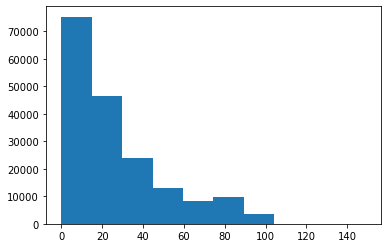

In [17]:
plt.hist(list(train_sample['clean_comment_text'].str.split().map(lambda x: len(x))))

In [32]:
print(train_sample['clean_comment_text'])

286892     breathe fresh air someone embrace common sense...
419218     jewish friend one tell zionist control canadav...
1055330    possible collusion trump affiliate debunk stat...
1382764    exactly need gdp spend cap federal level would...
256049     comment even vote ndp pq trudeau demonstrably ...
                                 ...                        
1654493    thank rebecca need tell entire story instead f...
1469254    deflection work sjsj fact feel need try divers...
236950     come afn dont keep fall political hat trick mu...
98687                                       larson vigilante
313137     dont believe youre trump supporter ive read nu...
Name: clean_comment_text, Length: 180487, dtype: object


In [18]:
np.median(np.array(train_sample['clean_comment_text'].str.split().map(lambda x: len(x))))

18.0

# Text Tokenization as Sequences

In [19]:
# Sequences creation, truncation and padding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Setting up the tokenizer
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'UNK')
tokenizer.fit_on_texts(list(train_sample['clean_comment_text']) + list(test['comment_text']))

max_len = 18
X_train_seq = tokenizer.texts_to_sequences(train_sample['clean_comment_text'])
X_test_seq = tokenizer.texts_to_sequences(test['comment_text'])

X_train_seq = pad_sequences(X_train_seq, maxlen = max_len, truncating = 'post', padding = 'post')
X_test_seq = pad_sequences(X_test_seq, maxlen = max_len, truncating = 'post', padding = 'post')
y_train = np.array(train_sample['target']).astype(int)

print(f"X_train shape: {X_train_seq.shape}")
print(f"X_test shape: {X_test_seq.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (180487, 18)
X_test shape: (97320, 18)
y_train shape: (180487,)


In [34]:
X_train_seq

array([[2515, 1877, 1304, ..., 1063, 3377, 3340],
       [  61,  215,  129, ...,  553, 4848, 2859],
       [ 161,  298, 2309, ...,  692,  136,    1],
       ...,
       [ 839,  294, 2436, ...,    0,    0,    0],
       [   1,  412,  389, ...,  128,  309,  328],
       [  32, 2469, 5576, ...,   15, 2477,   15]])

In [35]:
X_test_seq

array([[1863,  953,    9, ...,    0,    0,    0],
       [  25,    7, 8486, ...,    0,    0,    0],
       [   1, 5514,   19, ..., 3614,    4,  166],
       ...,
       [  12,  259,   11, ...,    0,    0,    0],
       [ 330, 1311, 9408, ..., 1050,    8,    2],
       [  12,   96,  441, ...,  936, 9128, 9450]])

In [20]:
from sklearn.model_selection import train_test_split

X_train_seq, X_val_seq, y_train, y_val = train_test_split(X_train_seq, y_train, test_size = 0.2, random_state = 42)

print(f"X_train shape: {X_train_seq.shape}")
print(f"X_val shape: {X_val_seq.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (144389, 18)
X_val shape: (36098, 18)
y_train shape: (144389,)
y_val shape: (36098,)


In [21]:
num_words = len(tokenizer.word_index)
print(f"Number of unique words: {num_words}")

Number of unique words: 221564


In [22]:
# Applying GloVE representations on our corpus

embedding_matrix=np.zeros((num_words,300))

for word,i in tokenizer.word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec    
            
embedding_matrix.shape

NameError: name 'embedding_dict' is not defined

In [23]:
# Setting up the model

from keras import layers
from keras.models import Sequential

def setup_lstm_model(max_len, n_latent_factors):
    
    model = Sequential()
    model.add(layers.Embedding(num_words, n_latent_factors, weights = [embedding_matrix], 
                               input_length = max_len, trainable = False))
    model.add(layers.LSTM(units = max_len, return_sequences = True))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))
    
    return model

In [24]:
lstm_model = setup_lstm_model(max_len = max_len, n_latent_factors = 300)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 300)           66469200  
_________________________________________________________________
lstm (LSTM)                  (None, 18, 18)            22968     
_________________________________________________________________
global_average_pooling1d (Gl (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 19        
Total params: 66,492,187
Trainable params: 22,987
Non-trainable params: 66,469,200
_________________________________________________________________


In [25]:
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

batch_size = 512
epochs = 5

lstm_model.fit(X_train_seq, y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_val_seq, y_val))

Epoch 1/5
283/283 [==============================] - 33s 36ms/step - loss: 0.2935 - val_loss: 0.0168
Epoch 2/5
283/283 [==============================] - 9s 31ms/step - loss: 0.0179 - val_loss: 0.0159
Epoch 3/5
283/283 [==============================] - 9s 30ms/step - loss: 0.0177 - val_loss: 0.0158
Epoch 4/5
283/283 [==============================] - 9s 31ms/step - loss: 0.0171 - val_loss: 0.0158
Epoch 5/5
283/283 [==============================] - 9s 30ms/step - loss: 0.0158 - val_loss: 0.0158


In [26]:
def setup_gru_model(max_len, n_latent_factors):
    
    model = Sequential()
    model.add(layers.Embedding(num_words, n_latent_factors, weights = [embedding_matrix], 
                               input_length = max_len, trainable = False))
    model.add(layers.GRU(units = max_len, return_sequences = True))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))
    
    return model

In [27]:
gru_model = setup_gru_model(max_len = max_len, n_latent_factors = 300)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 300)           66469200  
_________________________________________________________________
gru (GRU)                    (None, 18, 18)            17280     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 19        
Total params: 66,486,499
Trainable params: 17,299
Non-trainable params: 66,469,200
_________________________________________________________________


In [28]:
# Final hyperparameter configurations and fitting
gru_model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

batch_size = 512
epochs = 5

gru_model.fit(X_train_seq, y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_val_seq, y_val))

Epoch 1/5
283/283 [==============================] - 12s 31ms/step - loss: 0.3064 - val_loss: 0.0173
Epoch 2/5
283/283 [==============================] - 8s 29ms/step - loss: 0.0177 - val_loss: 0.0160
Epoch 3/5
283/283 [==============================] - 8s 28ms/step - loss: 0.0183 - val_loss: 0.0158
Epoch 4/5
283/283 [==============================] - 8s 29ms/step - loss: 0.0176 - val_loss: 0.0158
Epoch 5/5
283/283 [==============================] - 8s 29ms/step - loss: 0.0164 - val_loss: 0.0158


In [44]:
prediction = lstm_model.predict(X_test_seq)
text = re.sub('\[[^]]*\]', '', str(prediction))
print(prediction)



[[0.00264752]
 [0.00264752]
 [0.00264752]
 ...
 [0.00264752]
 [0.00264764]
 [0.00264764]]


In [56]:
pred = []
for i in range(len(prediction)):
    pred.append(prediction[i][0])
    

In [57]:
"""
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': prediction
})

"""
list_of_tuples = list(zip(test['id'], pred))
   
# Assign data to tuples.
list_of_tuples 
 
 
# Converting lists of tuples into
# pandas Dataframe.
submission = pd.DataFrame(list_of_tuples,
                  columns = ['id', 'prediction'])
    
# Print data.
submission.to_csv("submission.csv", index=False)

submission.head()

,id,prediction
0,7097320,0.002648
1,7097321,0.002648
2,7097322,0.002648
3,7097323,0.002648
4,7097324,0.002648


In [58]:
X_test_seq

array([[1863,  953,    9, ...,    0,    0,    0],
       [  25,    7, 8486, ...,    0,    0,    0],
       [   1, 5514,   19, ..., 3614,    4,  166],
       ...,
       [  12,  259,   11, ...,    0,    0,    0],
       [ 330, 1311, 9408, ..., 1050,    8,    2],
       [  12,   96,  441, ...,  936, 9128, 9450]])

In [59]:
test['id']

0        7097320
1        7097321
2        7097322
3        7097323
4        7097324
          ...   
97315    7194635
97316    7194636
97317    7194637
97318    7194638
97319    7194639
Name: id, Length: 97320, dtype: int64